In [18]:
# Standard library imports
import math
import os

# Related third party imports
import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from dotenv import load_dotenv
from google.cloud import bigquery
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, RobustScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, LSTM, LeakyReLU
import pydoc_data
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
# Local application/library specific imports
# (None in this example, but this is where they would go)
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense

# Load the environment variables from the .env file
load_dotenv()


True

In [82]:

google_credentials = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
PROJECT = "focus-hulling-416322"
DATASET = "2016"
TABLE = "out_and_in_2016_v4"

# Ensure the project, dataset, and table names are correctly formatted
# using backticks to avoid syntax errors
query = f"""
    SELECT *
    FROM `{PROJECT}.{DATASET}.{TABLE}`
"""

client = bigquery.Client(project=PROJECT)
query_job = client.query(query)
result = query_job.result()
data = result.to_dataframe()


In [83]:
data.dtypes

Patient_ID                             float64
Gender                                  object
age_years                              float64
region_mod                              object
Relationship_To_Primary_Beneficiary     object
Patient_Zipcode                        float64
Health_Plan_Type                        object
plan_typ                               float64
Clinic                                   Int64
drg                                      Int64
Clinic_visits                            Int64
Myocardial_infarction                  float64
chf                                    float64
pvd                                    float64
Cardiovascular_d                       float64
Respiratory_d                          float64
Hypertension                           float64
Diabetes_Melitus                       float64
Dementia                               float64
Kidney_disease                         float64
Liver_disease                          float64
Diarrheal_dis

In [95]:
# Cleaning the column names
df = data.clean_names()

# Changin the values inside the clinic column for onehot encoding
value_map = {1: 'Inpatient', 2: 'Outpatient'}
df['clinic'] = df['clinic'].map(value_map)

#Chaning the values for region_mod
value_map_2 = {'1': 'northeast', '2':'northcentral', '3':'south', '4':'west', '5':'unknown'}
df['region_mod'] = df['region_mod'].map(value_map_2)

#chaning the gender varible
value_map_3 = {'1':'male', '2':'female'}
df['gender'] = df['gender'].map(value_map_3)

# # Creating values for Plantype
# value_map_4 = {1: 'basic', 2: 'comprihensive', 3:'epo', 4:'hmo', 5:'pos', 6:'ppo', 7:'pos2', 8:'cdhp', 9:'hdhp'}


def encode_and_bind(original_dataframe, features_to_encode):

    # Convert a single feature name to a list
    if isinstance(features_to_encode, str):
        features_to_encode = [features_to_encode]

    # Check if the features exist in the dataframe
    for feature in features_to_encode:
        if feature not in original_dataframe.columns:
            raise ValueError(f"Feature '{feature}' not found in the dataframe")

    # One-hot encoding
    encoder = OneHotEncoder(sparse_output = False)
    encoder.fit(original_dataframe[features_to_encode])
    encoded_features = encoder.transform(original_dataframe[features_to_encode])

    # Add new encoded columns to the dataframe
    original_dataframe[encoder.get_feature_names_out(features_to_encode)] = encoded_features

    # Drop the original columns
    original_dataframe.drop(columns=features_to_encode, inplace=True)

    # Return the modified dataframe
    return original_dataframe

features_to_encode = ['clinic', 'region_mod', 'gender']

encode_and_bind(df, features_to_encode)

value_to_encode = [183, 184, 185, 521, 522, 533, 534, 545, 536, 542, 543, 544, 562, 563]
df['trauma'] = df['drg'].apply(lambda x: 1 if x in value_to_encode else 0)
df.loc[df['drg'].between(280, 283), 'myocardial_infarction'] += 1
df = df.drop(columns=['health_plan_type','plan_typ', 'drg', 'patient_zipcode'])
# repaet clean_names()
# df = df.clean_names()

# group_columns = ['patient_id', 'gender_male','relationship_to_primary_beneficiary']
agg_dict = {col: 'sum' for col in df.columns if col not in group_columns}
agg_dict['age_years'] = 'mean'
df = df.groupby(group_columns).agg(agg_dict).reset_index()

# #sorting out patient_id column
df['patient_id'] = df['patient_id'].astype(str)
df['patient_id'] = df['patient_id'].str.slice(0, -2)

# #eliminating the negative pay values
df = df[(df['age_years'] > 17) & (df['pay'].between(2,1000000))]

df = df.clean_names()
# #removing the duplicates
duplicates = df.duplicated(subset='patient_id', keep=False)
duplicate_rows= df[duplicates]
duplicate_rows.sort_values(by='patient_id')
df.drop_duplicates(inplace=True)
df['both_clinic'] = np.where((df['clinic_inpatient'] == 1.0) & (df['clinic_outpatient'] == 1.0), 1,0)


df = df.astype(float)
columns_to_replace = [
    'myocardial_infarction', 'trauma', 'chf', 'pvd', 'cardiovascular_d'
    'respiratory_d', 'hypertension', 'diabetes_melitus', 'dementia',
    'kidney_disease', 'liver_disease', 'diarrheal_disease', 'cancer',
    'metastasis', 'puc', 'hemiplegia', 'lymphoma', 'aids',
    'connective_tissue_disease', 'region_mod_northcentral',
    'region_mod_northeast', 'region_mod_south', 'region_mod_west',
    'region_mod_unknown', 'clinic_outpatient', 'clinic_inpatient', 'both_clinic', 'gender_female',
    'gender_male'
]
for column in columns_to_replace:
    if column in df.columns:
        # Create a mask for values greater than zero
        mask = df[column] > 0
        # Apply the mask and set those values to 1
        df.loc[mask, column] = 1


# CCI score
df['cci'] = 0
df['cci']= pd.cut(df['age_years'],
                    bins=[0, 49, 59, 69, 79, float('inf')],
                    labels=[0, 1, 2, 3, 4],
                    right=False).astype(int)
df.loc[df['myocardial_infarction'] == 1.0, 'cci'] +=1
df.loc[df['chf'] == 1.0, 'cci'] +=1
df.loc[df['pvd'] == 1.0, 'cci'] +=1
df.loc[df['respiratory_d'] == 1.0, 'cci'] +=1
df.loc[df['connective_tissue_disease'] == 1.0, 'cci'] +=1
df.loc[df['liver_disease'] == 1.0, 'cci'] +=1
df.loc[df['diabetes_melitus'] == 1.0, 'cci'] +=1
df.loc[df['kidney_disease'] == 1.0, 'cci'] +=1
df.loc[df['puc'] == 1.0, 'cci'] +=1
df.loc[df['hemiplegia'] == 1.0, 'cci'] +=2
df.loc[df['lymphoma'] == 1.0, 'cci'] +=2
df.loc[df['aids'] == 1.0, 'cci'] +=6
df.loc[df['cancer'] == 1.0, 'cci'] +=2
df.loc[df['metastasis'] == 1.0, 'cci'] +=6

scaling_columns = ['lohs', 'clinic_visits', 'age_years']
def scaler_minmax(data_frame, scaling_columns):
    minmax = MinMaxScaler()
    if isinstance(scaling_columns, str):  # If a single column name is passed as a string
        scaling_columns = [scaling_columns]  # Convert it to a list

    minmax.fit(data_frame[scaling_columns])
    data_frame[scaling_columns] = minmax.transform(data_frame[scaling_columns])
scaler_minmax(df, scaling_columns)



df
## relationship to primary beneficiary is to high, the numbers have been added up
## health plan type

,patient_id,age_years,relationship_to_primary_beneficiary,clinic_visits,myocardial_infarction,chf,pvd,cardiovascular_d,respiratory_d,hypertension,...,region_mod_northcentral,region_mod_northeast,region_mod_south,region_mod_unknown,region_mod_west,gender_female,gender_male,trauma,both_clinic,cci
0,2.030200e+04,0.914894,2.0,0.014272,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2
1,5.860200e+04,0.978723,2.0,0.001903,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
2,6.820200e+04,0.744681,33.0,0.074215,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2
3,1.476010e+05,0.914894,33.0,0.059943,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3
4,2.026030e+05,0.893617,2.0,0.050428,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298456,3.404381e+10,0.872340,1.0,0.006660,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3
2298457,3.404382e+10,0.297872,1.0,0.006660,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2298458,3.404382e+10,0.723404,2.0,0.028544,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
2298459,3.404382e+10,0.382979,1.0,0.003806,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [96]:

df['myocardial_infarction'].value_counts()
# 0.0    2021823
# 1.0      10997

myocardial_infarction
0.0    2021823
1.0      10997
Name: count, dtype: int64

In [97]:
print(df['clinic_inpatient'].value_counts())
print(df['clinic_outpatient'].value_counts())
print(df['both_clinic'].value_counts())
print(df['gender_female'].value_counts())
print(df['gender_male'].value_counts())
print(df['region_mod_unknown'].value_counts())
print(df['age_years'].mean())
print(df['diabetes_melitus'].value_counts())
print(df['lohs'].mean())


clinic_inpatient
0.0    1789957
1.0     242863
Name: count, dtype: int64
clinic_outpatient
1.0    2032555
0.0        265
Name: count, dtype: int64
both_clinic
0.0    1845385
1.0     187435
Name: count, dtype: int64
gender_female
0.0    1262051
1.0     770769
Name: count, dtype: int64
gender_male
1.0    1262051
0.0     770769
Name: count, dtype: int64
region_mod_unknown
0.0    2024214
1.0       8606
Name: count, dtype: int64
0.6674917267219399
diabetes_melitus
0.0    1715965
1.0     316855
Name: count, dtype: int64
0.0019333601453801641


In [98]:

df.columns

Index(['patient_id', 'age_years', 'relationship_to_primary_beneficiary',
       'clinic_visits', 'myocardial_infarction', 'chf', 'pvd',
       'cardiovascular_d', 'respiratory_d', 'hypertension', 'diabetes_melitus',
       'dementia', 'kidney_disease', 'liver_disease', 'diarrheal_disease',
       'cancer', 'metastasis', 'connective_tissue_disease', 'puc',
       'hemiplegia', 'lymphoma', 'aids', 'lohs', 'coinsurance', 'copay',
       'deductable', 'net', 'pay', 'clinic_inpatient', 'clinic_outpatient',
       'region_mod_northcentral', 'region_mod_northeast', 'region_mod_south',
       'region_mod_unknown', 'region_mod_west', 'gender_female', 'gender_male',
       'trauma', 'both_clinic', 'cci'],
      dtype='object')

(array([5.71116e+05, 5.60893e+05, 0.00000e+00, 4.38103e+05, 2.25105e+05,
        0.00000e+00, 1.21627e+05, 4.73660e+04, 0.00000e+00, 1.93380e+04,
        1.04470e+04, 0.00000e+00, 1.08330e+04, 1.00490e+04, 0.00000e+00,
        8.96500e+03, 5.22600e+03, 0.00000e+00, 2.37300e+03, 8.73000e+02,
        0.00000e+00, 3.00000e+02, 1.04000e+02, 0.00000e+00, 4.90000e+01,
        3.20000e+01, 0.00000e+00, 1.50000e+01, 4.00000e+00, 2.00000e+00]),
 array([ 0.        ,  0.66666667,  1.33333333,  2.        ,  2.66666667,
         3.33333333,  4.        ,  4.66666667,  5.33333333,  6.        ,
         6.66666667,  7.33333333,  8.        ,  8.66666667,  9.33333333,
        10.        , 10.66666667, 11.33333333, 12.        , 12.66666667,
        13.33333333, 14.        , 14.66666667, 15.33333333, 16.        ,
        16.66666667, 17.33333333, 18.        , 18.66666667, 19.33333333,
        20.        ]),
 <BarContainer object of 30 artists>)

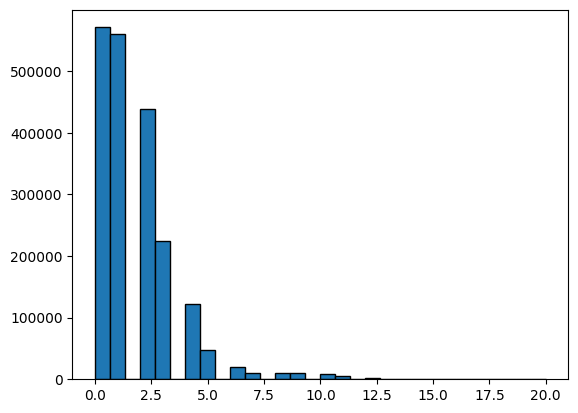

In [99]:
import matplotlib.pyplot as plt
plt.hist(df['cci'], bins=30, edgecolor='black')
# df['cci'].describe()

In [101]:
df.columns

Index(['patient_id', 'age_years', 'relationship_to_primary_beneficiary',
       'clinic_visits', 'myocardial_infarction', 'chf', 'pvd',
       'cardiovascular_d', 'respiratory_d', 'hypertension', 'diabetes_melitus',
       'dementia', 'kidney_disease', 'liver_disease', 'diarrheal_disease',
       'cancer', 'metastasis', 'connective_tissue_disease', 'puc',
       'hemiplegia', 'lymphoma', 'aids', 'lohs', 'coinsurance', 'copay',
       'deductable', 'net', 'pay', 'clinic_inpatient', 'clinic_outpatient',
       'region_mod_northcentral', 'region_mod_northeast', 'region_mod_south',
       'region_mod_unknown', 'region_mod_west', 'gender_female', 'gender_male',
       'trauma', 'both_clinic', 'cci'],
      dtype='object')

### outliers ###

## Preparing the X and the y

In [109]:
# Preparing the data

X = df.drop(columns=['pay', 'clinic_outpatient', 'patient_id', 'coinsurance', 'copay', 'deductable', 'net', 'region_mod_unknown'])

y = df['pay']


In [106]:
X

,age_years,relationship_to_primary_beneficiary,clinic_visits,myocardial_infarction,chf,pvd,cardiovascular_d,respiratory_d,hypertension,diabetes_melitus,...,clinic_inpatient,region_mod_northcentral,region_mod_northeast,region_mod_south,region_mod_west,gender_female,gender_male,trauma,both_clinic,cci
0,0.914894,2.0,0.014272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2
1,0.978723,2.0,0.001903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
2,0.744681,33.0,0.074215,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2
3,0.914894,33.0,0.059943,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3
4,0.893617,2.0,0.050428,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298456,0.872340,1.0,0.006660,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3
2298457,0.297872,1.0,0.006660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
2298458,0.723404,2.0,0.028544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
2298459,0.382979,1.0,0.003806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


## The Decision Tree Regressor

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cv_result = cross_validate(DecisionTreeRegressor(max_depth=8, min_samples_leaf=7, min_samples_split=30), X_train, y_train, cv=5, scoring='r2')
test_score = cv_result['test_score'].mean()
print(test_score)


0.6085062832626091


# Gradient Boosting Machine

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [111]:
gbm = cross_validate(GradientBoostingRegressor(n_estimators=200,
                                               learning_rate=0.1,
                                               min_samples_leaf=7,
                                               max_depth=8,
                                               min_samples_split=30,
                                               random_state=42),
                     X_train,
                     y_train,
                     cv=5,
                     scoring='r2')

test_score_gbm = gbm['test_score'].mean()
test_score_gbm

In [122]:
gbm = GradientBoostingRegressor(n_estimators=200,
                                min_samples_split=30,
                                min_samples_leaf=7,
                                max_depth=8 ,
                                learning_rate=0.1,
                                random_state=42)
gbm.fit(X_train, y_train)

y_pred = gbm.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
#670160468.497997

Mean Squared Error: 662402098.5054079


# Comparing models

In [108]:
from keras.optimizers.legacy import Adam
from tensorflow.keras import regularizers
# Load dataset

X = X.astype(float)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = models.Sequential()
model.add(layers.Dense(30, activation= 'relu', input_shape=(X.shape[1],),
                       kernel_regularizer=regularizers.l1(0.01)))
model.add(layers.Dense(30, activation='relu',
                       kernel_regularizer=regularizers.l1(0.01)))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='relu',
                       kernel_regularizer=regularizers.l1(0.01)))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))


# eraly stopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=15,
                               verbose =1,
                               restore_best_weights=True)


# # Compile the model
model.compile(optimizer=Adam(learning_rate = 0.01),
              loss='mean_absolute_error',
              metrics=[('mae', 'accuracy')])

# Train the model
model.fit(X_train, y_train, epochs=59, batch_size=32, validation_split=0.3, callbacks=[early_stopping])

# Evaluate the model on test data
results = model.evaluate(X_test, y_test)
# print(f'Test loss: {test_loss}')

/Users/amermujkanovic/.pyenv/versions/3.10.6/envs/RaphaelHealth/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ImportError: `keras.optimizers.legacy` is not supported in Keras 3. When using `tf.keras`, to continue using a `tf.keras.optimizers.legacy` optimizer, you can install the `tf_keras` package (Keras 2) and set the environment variable `TF_USE_LEGACY_KERAS=True` to configure TensorFlow to use `tf_keras` when accessing `tf.keras`.

In [61]:
results

# 7788.56640625, 7788.56640625


[7868.2763671875, 7836.2109375, 0.0]

In [187]:
np.sqrt(results[0])
# 32131.827461257162

26110.428874302313